# Jet Clustering using "Smart Topo-Clusters"

The big idea is to use neural networks for classification and/or energy calibration of topo-clusters, and use these topo-clusters for making jets. In this notebook I'll be playing around with some ideas for this, to see what works.

In this notebook we will *not* be training neural networks. That's taken care of by other notebooks in the `/classifier` and `/regression` directories of this repo. We will instead be applying the existing, trained networks to some data.

#### 1) Setup

First, let's import a bunch of packages we know we'll need right off-the-bat.

Note that as we've set up our environment with `conda`, our `ROOT` installation has all the bells and whistles. This includes the `pythia8` library and its associated `ROOT` wrapper, `TPythia8`. We can optionally use this for jet-clustering, as it comes `fj-core`.
Alternatively we could use the Pythonic interface for `fastjet` or [pyjet](https://github.com/scikit-hep/pyjet), but the latter requires linking an external fastjet build for speed and this doesn't seem to work when following their documentation.

In [1]:
import numpy as np
import ROOT as rt
import uproot as ur
#import pandas as pd
import sys, glob

Welcome to JupyROOT 6.22/02


Here's also some slightly contrived setup for `latex`. We may need this for the `atlas_mpl_style` package, which is employed in some of Max's plotting utilities that we may want to borrow. Since `latex` isn't set up on the [UChicago ML platform](https://ml.maniac.uchicago.edu) by default, our setup script may install it separately but it's still not on `$PATH` since we don't touch our bash profile. This cell uses some `IPython` magic to adjust `$PATH` for this notebook.

In [2]:
# Check if latex is set up already.
# We use some Jupyter magic -- alternatively one could use python's subprocess here.
has_latex = !command -v latex
has_latex = (not has_latex == [])

# If latex was not a recognized command, our setup script should have installed
# at a fixed location, but it is not on the $PATH. Now let's use some Jupyter magic.
# See https://ipython.readthedocs.io/en/stable/interactive/shell.html for info.
if(not has_latex):
    latex_prefix = '/usr/local/texlive/2020/bin/x86_64-linux'
    jupyter_env = %env
    path = jupyter_env['PATH']
    path = path + ':' + latex_prefix
    %env PATH = $path
    jupyter_env = %env
    path = jupyter_env['PATH']

env: PATH=/opt/conda/envs/ml4p/bin:/opt/conda/condabin:/usr/local/nvidia/bin:/usr/local/cuda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/usr/local/texlive/2020/bin/x86_64-linux


In [3]:
# some extra setup
path_prefix = '/workspace/LCStudies/'

#### 2) Fetching the data

Now we get our data. For now, our classifiers are being trained to distinguish between $\pi^+$ and $\pi^0$. Assuming that all charged pions behave the same way, we can really treat this as a $\pi^\pm$ vs. $\pi^0$ classifier. **For our toy workflow, we'll say that we only want to cluster $\pi^\pm$ topo-clusters into jets.** We will treat $\pi^0$ as a background.

For our input data, we have `ROOT` files containing a tree called `ClusterTree`. In each tree, each entry corresponds with one topo-cluster, and the different files correspond with different topo-cluster parent particles (e.g. $3$ files for $\pi^+$,$\pi^-$ and $\pi^0$). Each topo-cluster entry contains information on the event from which it came ("runNumber" and "eventNumber"), and many topo-clusters (within and across files) share the same event. Our ultimate goal is to regroup this data into one file where each entry corresponds with one *event*. This is a sensible way to arrange the data before performing any jet clustering (which is performed by event), and writing to a file will allow us to skip this whole process after doing it once.

In [4]:
if(path_prefix not in sys.path): sys.path.append(path_prefix)
from  util import ml_util as mu

# ----- Meta-data for our dataset -----
layers = ["EMB1", "EMB2", "EMB3", "TileBar0", "TileBar1", "TileBar2"]
nlayers = len(layers)
cell_size_phi = [0.098, 0.0245, 0.0245, 0.1, 0.1, 0.1]
cell_size_eta = [0.0031, 0.025, 0.05, 0.1, 0.1, 0.2]
len_phi = [4, 16, 16, 4, 4, 4]
len_eta = [128, 16, 8, 4, 4, 2]
assert(len(len_phi) == nlayers)
assert(len(len_eta) == nlayers)
meta_data = {
    layers[i]:{
        'cell_size':(cell_size_eta[i],cell_size_phi[i]),
        'dimensions':(len_eta[i],len_phi[i])
    }
    for i in range(nlayers)
}
# -------------------------------------

# We open the files using uproot, and use our ml_util to get the images.
data_dir = '/workspace/LCStudies/data'
data_files = glob.glob(data_dir + '/*.root')
data_files = {x.split('/')[-1].replace('.root',''):x for x in data_files}
tree_name = 'ClusterTree'
trees = {key: ur.open(file)[tree_name] for key, file in data_files.items()}

pcells = {
    ifile : {
        layer : mu.setupCells(itree, layer)
        for layer in layers
    }
    for ifile, itree in trees.items()
}

#### 3) Applying the classifier network

Our first step is to get the network scores for each topo-cluster. We will place these in "friend trees" of our input trees. (To be more precise, we will chain together the input trees, and the trees we make here, and then make these $2$ `TChain`s friends).

To do this, let's import some `tensorflow` and `keras` stuff that we'll need for applying our trained networks to the data.

In [5]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # disable some of the tensorflow info printouts, only display errors
ngpu = 1
gpu_list = ["/gpu:"+str(i) for i in range(ngpu)]
import tensorflow as tf
strategy = tf.distribute.MirroredStrategy(devices=gpu_list)
ngpu = strategy.num_replicas_in_sync
print ('Number of devices: {}'.format(ngpu))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of devices: 1


In [6]:
import pickle
from  util import qol_util as qu
modelpath = path_prefix + 'classifier/Models'
model_postfix = '_flat_do20' # for our simple, per-layer NN's
models = {}
model_history = {}
model_scores = {}

i = 0
for layer in layers:
    if(i == 0): print('Loading ',end='')
    print(layer,end='')
    if(i!= len(layers)-1): print(', ',end='')
    else: print('.')
    i += 1
    
    models[layer] = tf.keras.models.load_model(modelpath+'/model_' + layer + model_postfix + '.h5')
    # Load history object.
    with open(modelpath + '/model_' + layer + model_postfix + '.history','rb') as model_history_file:
        model_history[layer] = pickle.load(model_history_file)
    
# Recalculate network scores for the datasets.
prefix = 'Calculating network scores:'
l = len(pcells) * len(layers)
qu.printProgressBar(0, l, prefix=prefix, suffix='Complete', length=50)
i = 0
for key in pcells.keys():
    
    model_scores[key] = {}
    for layer in layers: 
        model_scores[key][layer] = models[layer].predict(pcells[key][layer])
        i += 1
        qu.printProgressBarColor(i, l, prefix=prefix, suffix='Complete', length=50)

Loading EMB1, EMB2, EMB3, TileBar0, TileBar1, TileBar2.
Calculating network scores: |██████████████████████████████████████████████████| 100.0% Complete


For each event, the corresponding `model_scores` entry is a tuple.
The first entry is the "background score" -- how likely the cluster is to be a $\pi^0$. The second is the "signal score" -- how likely the cluster is to be a $\pi^\pm$. At least this seems to be the correct interpretation.

### 4) Saving network scores and signal flags to clusters

Now that we have our network scores for all our clusters, we need to group our clusters by event -- in a new file. As each entry will correspond with one event, most of our scalar branches will now become arrays, listing properties for each cluster in the event. We could try to be fancy and make these branches of C++-type `std::vector` instead, but as some are multi-dim arrays we would end up with vectors of C++-style arrays and handling these via the `PyROOT` interface seems problematic/tough to me.


Note that besides the signal flag and network scores, we're also adding a "file index". This is a simple constant branch that keeps the entries from different files distinct. It could, in principle, let us distinguish underlying truth particle flavors beyond just "signal" and "background" (e.g. distinguish between $\pi^+$ and $\pi^-$).

In [19]:
sig_definition = {'signal':['piminus','piplus'],'background':['pi0']}

from  util import qol_util as qu
from pathlib import Path
jet_data_dir = path_prefix + 'jets/data'
Path(jet_data_dir).mkdir(parents=True, exist_ok=True)

# Get our original data files.
files = {key:rt.TFile(file,'READ') for key, file in data_files.items()}
trees = {key:file.Get(tree_name) for key, file in files.items()}

# Now we want to effectively add some new columns. We accomplish this with "friend" trees.
# We're not actually making these trees friends yet. Instead we will form TChains and friend those.

# Creating our branch buffer.
data = {
    'signal':np.zeros(1,dtype=np.dtype('i2')),
    'file_index'   :np.zeros(1,dtype=np.dtype('i2')) # TODO: Is this needed any longer?
}
for layer in layers:
    bname = layer + '_NN'
    data[bname] = np.zeros(2,dtype=np.dtype('f8'))

friend_tree_name = tree_name + '_friend'
friend_data_files = {}

file_index = 0
stride = 200

for key in sorted(trees.keys()):
    
    friend_filename = data_files[key].split('/')[-1]
    friend_filename = jet_data_dir + '/' + friend_filename
    friend_file = rt.TFile(friend_filename,'RECREATE')
    friend_data_files[key] = friend_filename
    
    friend_tree = rt.TTree(friend_tree_name,friend_tree_name)
    branches = {}

    # --- Setup the branches using our buffer. This is a rather general/flexible code block. ---
    for bname, val in data.items():
        descriptor = bname
        bshape = val.shape
        if(bshape != (1,)):
            for i in range(len(bshape)):
                descriptor += '[' + str(bshape[i]) + ']'
        descriptor += '/'
        if(val.dtype == np.dtype('i2')): descriptor += 'S'
        elif(val.dtype == np.dtype('i4')): descriptor += 'I'
        elif(val.dtype == np.dtype('i8')): descriptor += 'L'
        elif(val.dtype == np.dtype('f4')): descriptor += 'F'
        elif(val.dtype == np.dtype('f8')): descriptor += 'D'
        else:
            print('Warning, setup issue for branch: ', key, '. Skipping.')
            continue
        branches[key] = friend_tree.Branch(bname,val,descriptor)
    # --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- ---
    
    # Now we fill the friend tree.
    nentries = trees[key].GetEntries()
    for layer in layers: assert len(model_scores[key][layer]) == nentries

    # Signal flag and file index will be constant since input trees are divided by particle identity.
    sig = 0
    if(key in sig_definition['signal']): sig = 1
    nn_scores = model_scores[key]
    
    prefix = 'Filling friend tree for ' + key + ':'
    if(len(prefix) < 32): prefix = prefix + ' ' * (32 - len(prefix))
    qu.printProgressBar(0, int(nentries/100), prefix=prefix, suffix='Complete', length=50)
    
    for i in range(nentries):
        data['signal'][0] = sig
        for layer in layers: data[layer + '_NN'][:] = nn_scores[layer][i,:]
        friend_tree.Fill()
        if(i%stride ==0): qu.printProgressBarColor(i/stride, int(nentries/stride), prefix=prefix, suffix='Complete', length=50)
    
    friend_tree.Write()
    friend_file.Close()
    file_index += 1

Filling friend tree for pi0:     |██████████████████████████████████████████████████| 100.0% Complete
Filling friend tree for piminus: |██████████████████████████████████████████████████| 100.0% Complete
Filling friend tree for piplus:  |██████████████████████████████████████████████████| 100.0% Complete


### 5) Merging topo-cluster data, writing to a file and creating an eventNumber index

Our trees containing the signal flag and network scores are now saved to disk. Now let's make `TChain`s and make them friends, so that we've effectively tacked on new columns to our original data. We will then save these `TChain`s as a `TTree` to an uncompressed file, and use the `TTreeIndex` functionality to sort our events. We do this conversion & saving because it appears to greatly speed up our reading when using the `TTreeIndex`. I assume this has to do something with the entries -- from both the main chain and its friend -- all being saved in the same file as opposed to being scattered across multiple ones. ([See here](https://root-forum.cern.ch/t/usage-of-tchainindex/19074/4) for a discussion of `TChainIndex` versus `TTreeIndex`).


In [8]:
chain = rt.TChain(tree_name)
friend_chain = rt.TChain(friend_tree_name)
for key in data_files.keys(): 
    chain.AddFile(data_files[key],-1)
    friend_chain.AddFile(friend_data_files[key],-1)
    
chain_filename = jet_data_dir + '/' + 'clusters.root'
chain_file = rt.TFile(chain_filename,'RECREATE','',0) # uncompressed file
clone = chain.CloneTree(-1,'FAST')
friend_clone = friend_chain.CloneTree(-1,'FAST')
clone.Write()
friend_clone.Write()
chain_file.Close()

In [9]:
chain_file = rt.TFile(chain_filename,'READ')
chain = chain_file.Get(tree_name)
friend_chain = chain_file.Get(friend_tree_name)
assert(chain.GetEntries() == friend_chain.GetEntries()) # number of entries must match, otherwise something has gone very wrong
nentries = chain.GetEntries()
chain.AddFriend(friend_chain)
print('The chains are now friends.')

The chains are now friends.


### 6) Preparing to create an event TTree

Interestingly, one of the branches of the input data is of type `std::vector<Float_t>`, while all the others are either scalars or fixed-length arrays (sometimes with an effective variable length encoded in another branch). Let's see what the length of this vector branch looks like.

Drawing: |██████████████████████████████████████████████████| 100.0% Complete
Max length is 786.


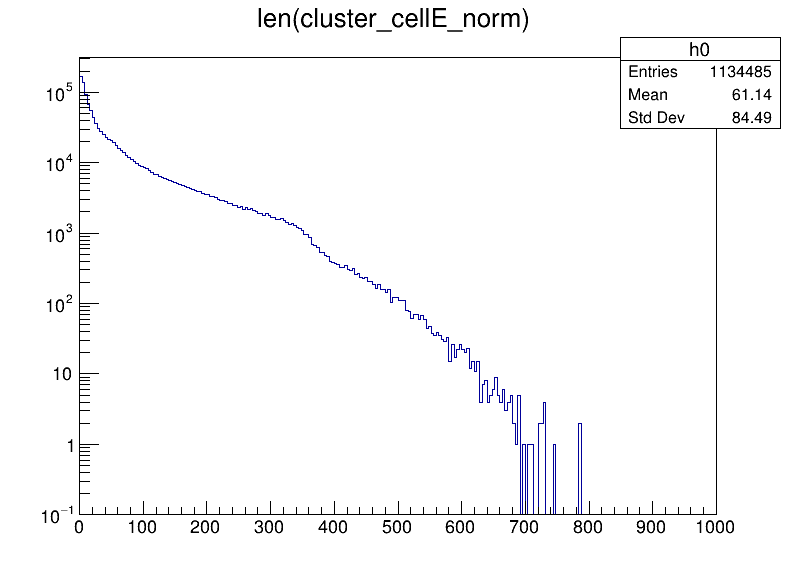

In [10]:
# Investigating the cluster_cellE_norm branch, which is the only vector branch (variable-length). Why?
histo = rt.TH1I('h0','len(cluster_cellE_norm)',250,0,1000)
nentries = chain.GetEntriesFast()
stride = 200
qu.printProgressBar(0, int(nentries/stride), prefix='Drawing:', suffix='Complete', length=50)
chain.SetBranchStatus('*',0)
chain.SetBranchStatus('cluster_cellE_norm',1)
for i in range(nentries):
    chain.GetEntry(i)
    histo.Fill(len(chain.cluster_cellE_norm))
    if(i%stride == 0): qu.printProgressBarColor(i/stride, int(nentries/stride), prefix='Drawing:', suffix='Complete', length=50)

canv = rt.TCanvas('c1,','c1',800,600)
histo.Draw('HIST')
canv.SetLogy()
histo.SetMinimum(0.1)
canv.Draw()

max_length = int(histo.GetXaxis().GetBinCenter(histo.FindLastBinAbove(0)))
print('Max length is ' + str(max_length) + '.')

Now let's make a function to quickly get the maximum length of a vector branch in our tree. We only have one vector branch for now but there may be others with a future dataset.

This will let us turn the branch from one of type vector to one of type array. It's useful if we're adding an extra dimension, as I'm currently having issues with making branches like vectors of arrays on the Python side of things.

In [11]:
def GetMaxVectorLength(chain, branchname):
    draw_string = branchname + '@.size()'
    chain.Draw(draw_string)
    h = rt.gPad.GetPrimitive('htemp') # some slightly idiomatic ROOT stuff, one of the few examples of weird default behavior
    max_length = int(h.GetXaxis().GetBinCenter(h.FindLastBinAbove(0)))
    return max_length

Now we will create our `TTreeIndex`. We will use the branch `eventNumber` as our `majornumber`, so that the index effectively sorts our tree by `eventNumber` and we have our events grouped together. Since there are many duplicate `eventNumber` entries, and we do not use any `minornumber`, this is *not* a unique index. But this is fine, because we do not care about the sorting within any single `eventNumber` value. It just means that we *cannot* access every single entry with a call to `TTreeIndex::GetEntryNumberWithIndex()`, but rather we'll have to loop through the elements of `TTreeIndex:GetIndex()` sequentially.

**TODO:** As a consequence of our indexing, we do not protect against the possibility of two clusters having the same `eventNumber` but different `runNumber`s. We should add this at some point to avoid the possibility of mixing clusters from what are really separate events.

In [12]:
# setting minornumber to 0 effectively gets rid of it
chain.SetBranchStatus('*',0)
chain.SetBranchStatus('eventNumber',1)
chain_idx = rt.TTreeIndex(chain,'eventNumber','0') # TODO: consider changing to majornumber=runNumber, minorNumber=eventNumber. In this particular case runNumber is always the same.
n_idx = chain_idx.GetN()
assert(n_idx == chain.GetEntriesFast()) # ensure our TTreeIndex is of the right length, otherwise something is wrong
chain_indices = chain_idx.GetIndex() # a C++-style array of (ROOT) type Long64_t...
chain_indices = np.array([chain_indices[i] for i in range(n_idx)],dtype=np.dtype('i8')) #... now a numpy array

Let's determine the maximum number of topo-clusters per event. We can set a naïve upper bound with nfiles * max(nCluster), but the actual upper bound is probably lower than this.

In [13]:
chain.SetBranchStatus('*',0)
chain.SetBranchStatus('eventNumber',1)
chain.SetBranchStatus('nCluster',1)

n_clusters_max = 0
max_tmp = 0

chain.GetEntry(0)
eN_prev = chain.eventNumber

nentries = chain.GetEntries()
stride = int(nentries/100)
l = int(nentries/stride)
bar_length = 120
prefix = 'Finding max nClusters'
qu.printProgressBar(0, l, prefix=prefix, suffix='Complete', length=bar_length)
for i in range(nentries):
    idx = chain_indices[i]
    chain.GetEntry(idx)
    if(chain.eventNumber != eN_prev):
        if(max_tmp > n_clusters_max): n_clusters_max = max_tmp
        max_tmp = 0
    max_tmp += 1
    eN_prev = chain.eventNumber
    if(i%stride == 0): qu.printProgressBar(int(i/stride), l, prefix=prefix, suffix='Complete', length=bar_length)
    
print('max(nClusters) per event =',n_clusters_max)

Finding max nClusters |████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% Complete
max(nClusters) per event = 34


Now we want to copy our data to a new `ROOT` file, where each entry corresponds with an **event**. Our `chain_indices` lets us loop through the existing data in a sensible way.

Certain variables are *per-event* variables, such as `runNumber`. These will remain as scalars. Other variables are *per-cluster* variables, such as `clusterE` (scalar) or `EMB1` (2D vector). These will become *arrays* of whatever their previous type was. The branch `nCluster` will keep track of their length for each event. Note that this means we be rewriting the contents of the `nCluster` branch, rather than copying it over -- it currently only keeps track of the number of clusters per event per file, not the total number of clusters per event.

As one last note, we will have to be a little careful about looping through our `TChain` of input trees for the sake of speed. We're using a `TTreeIndex` that we built, but this will amount to hopping around a lot (reading entries in a very non-sequential order w.r.t. the chain/trees). [This can slow things down with a lot of file I/0](https://root-forum.cern.ch/t/ttree-getentry-with-a-ttreeindex-is-too-slow/17370/5).

In [14]:
# Converting from ROOT type names to leaflist decorators.
# Vector decorator will not work, but gives a sensible string
# telling us the depth (how many vectors).
def RTypeConversion(type_string):
    if(type_string == 'Short_t' or type_string == 'short'):    return 'S'
    elif(type_string == 'Int_t' or type_string == 'int'):    return 'I'
    elif(type_string == 'Float_t' or type_string == 'float'):  return 'F'
    elif(type_string == 'Double_t' or type_string == 'double'): return 'D'
    elif('vector' in type_string): # special case
#         type_substring = '<'.join(type_string.split('<')[1:])
#         type_substring = '>'.join(type_substring.split('>')[:-1])
#         type_substring = RTypeConversion(type_substring)
#         return 'v_' + type_substring
        return type_string
    else: return '?'

def GetShape(shape_string):
    dims = shape_string.replace('[',' ').replace(']', ' ').split()
    return tuple([int(x) for x in dims])

def RType2NType(type_string):
    if(type_string == 'S'):   return np.dtype('i2')
    elif(type_string == 'I'): return np.dtype('i4')
    elif(type_string == 'L'): return np.dtype('i8')
    elif(type_string == 'F'): return np.dtype('f4')
    elif(type_string == 'D'): return np.dtype('f8')
    else: raise ValueError('Input not understood.')

In [15]:
# Explicitly turn on all branches.
chain.SetBranchStatus('*',1)
friend_chain.SetBranchStatus('*',1)

# n_clusters_max = int(len(data_files.keys()) * chain.GetMaximum('nCluster')) # safe upper limit, but might be unnecessarily high

# Building our branch buffer for our new trees. This time we'll add leaflists to the buffer as well.
# Slightly hacky but this should be pretty flexible for any basic-type branches.

branch_info = [x.GetListOfLeaves()[0] for x in chain.GetListOfBranches()]
branch_info = [(x.GetTitle(),x.GetTypeName()) for x in branch_info]
branch_names = [x[0].split('[')[0] for x in branch_info]

friend_branch_info = [x.GetListOfLeaves()[0] for x in friend_chain.GetListOfBranches()]
friend_branch_info = [(x.GetTitle(),x.GetTypeName()) for x in friend_branch_info]
friend_branch_names = [x[0].split('[')[0] for x in friend_branch_info]

branch_names = branch_names + friend_branch_names
branch_info = branch_info + friend_branch_info

# Now let's consider removing some branches that we don't think we'll need for our event dataset.
# This can potentially speed things up a lot. Especially true for branches of type std::vector at the moment,
# as I am probably not handling them in the smartest way.
branch_names_remove = ['cluster_cellE_norm']

rtypes_forced = {'nCluster':'S'}

perEvent = ['runNumber','eventNumber','nCluster','file_index'] # keep track of which branches only need one entry per event
vector_branches = [] # keep track of any branches that are of (C++) type std::vector

# We must also keep track of the original shapes of any array branches that we read, as they will be read out as 1D cppy arrays
# and will need to be reshaped before being placed in our buffer.
input_shapes = {}

branch_buffer = {}
for entry in branch_info: 
    name = entry[0]
    shape = (1,)
    shape_string = ''
    if('[' in name): 
        shape_string = '[' + '['.join(name.split('[')[1:])
        shape = GetShape(shape_string)
    name = name.split('[')[0]
    
    rtype = RTypeConversion(entry[1])    
    if(name in rtypes_forced.keys()): rtype = rtypes_forced[key]
    
    if(name in branch_names_remove): continue
    
#     report = 'Setting up branch ' + str(name)
#     report_length = len(report)
#     if(report_length < 50):
#         report += (50-report_length) * ' '
#     report2 = 'Original shape is ' + str(shape)
#     if(len(report2)) < 30:
#         report2 += (30-len(report2)) * ' '
#     print(report,report2,end='')
    
    # save the original shapes of non-scalar branches
    if(shape != (1,)): input_shapes[name] = shape # save the original shape

    if(name not in perEvent):
        if(shape == (1,)): 
            shape = (n_clusters_max,)
            shape_string = '[' + 'nCluster' + ']'
        else:
            shape2 = [n_clusters_max]
            for x in shape: shape2.append(x)
            shape = tuple(shape2)
            shape_string = '[' + 'nCluster' + ']' + shape_string
      
#         print('->\t',shape)
    if('vector' in rtype):
        continue
        # We will make the vector into an array. Assuming vector is of some basic type! (not vector of vectors, etc.)
        rsubtype = '<'.join(rtype.split('<')[1:])
        rsubtype = '>'.join(rsubtype.split('>')[:-1])
        rtype = RTypeConversion(rsubtype)
        n_max = GetMaxVectorLength(chain,name)
        input_shapes[name]=(n_max,)
        shape = tuple(list(shape) + [n_max])
        shape_string += '[' + str(n_max) + ']'
        vector_branches.append(name)
        #branch_buffer[name] = [rt.vector(rsubtype)(),0]
        #TODO: Add a branch for the vector length
        
    branch_buffer[name] = [np.zeros(shape,dtype=RType2NType(rtype)),name + shape_string + '/' + rtype]   

### 7) Creating event TTree

Now we're really ready to make our event TTree -- each entry will correspond with a full event, and hold all of its topo-clusters.

In [16]:
# Determining how many events to write. By default we want them all, but for debugging we might only want some subset.
nevents = 80000
nentries = chain_indices.shape[0]
if(nevents > 0):
    # determine how many entries we need to get this many events
    chain.SetBranchStatus('*',0)
    chain.SetBranchStatus('eventNumber',1)
    nevents_tally = 0
    chain.GetEntry(chain_indices[0])
    eN_prev = chain.eventNumber
    for i in range(nentries):
        chain.GetEntry(chain_indices[i])
        if(chain.eventNumber != eN_prev): nevents_tally += 1
        eN_prev = chain.eventNumber
        if(nevents_tally == nevents):
            nentries = i-1 # don't include the event we've just started
            break
            
if(nevents <= 0): nevents = 'all'
report_string = 'Preparing to write {nev} events, corresponding to {nen} input topo-clusters.'.format(nev=nevents,nen=nentries)
print(report_string)

Preparing to write 80000 events, corresponding to 343128 input topo-clusters.


In [17]:
# Activate the branches we need, keep any ignored ones deactivated
chain.SetBranchStatus('*',1)
for name in branch_names_remove: chain.SetBranchStatus(name,0)
    
# Strategies for speeding things up more. 
strategy = 3

if(strategy == 1 or strategy == 3):
    filesize = chain_file.GetSize() # in bytes
    chain.SetMaxVirtualSize(int(1.5 * filesize))
    for name in branch_names:
        if(name not in branch_names_remove): chain.GetBranch(name).LoadBaskets()
    print('Employing strategy 1 (load full input tree into memory).')

if(strategy == 2 or strategy == 3):
    # Increasing basket_size will help a little. But because entry access is somewhat random,
    # with each event's clusters generally spread out into multiple small groups of adjacent entries,
    # performance will quickly plateau and big increases may not give any real gains.
    basket_size_multiplier = 3
    basket_size = 16000 * basket_size_multiplier
    for name in branch_names:
        if(name in branch_names_remove): continue
        if(name in friend_branch_names): friend_chain.SetBasketSize(name,basket_size)
        else: chain.SetBasketSize(name,basket_size)
    print('Employing strategy 2 (increasing basket size for input tree).')

Employing strategy 1 (load full input tree into memory).
Employing strategy 2 (increasing basket size for input tree).


Now we're *really* ready to write our event tree.

In [18]:
#TODO: Deal with read/write bugging out at 99% when trying to write the full dataset. Works fine for subsets.

import time
from pathlib import Path
Path(jet_data_dir).mkdir(parents=True, exist_ok=True)

# Make the new TFile and TTree.
event_filename = path_prefix + 'jets/data' + '/' + 'events.root'
event_treename = 'events'
event_file = rt.TFile(event_filename,'RECREATE','',0) # TODO: Making this uncompressed for debugging purposes
event_tree = rt.TTree(event_treename,event_treename)
#event_tree.SetDirectory(0) # tree will start in memory!

# Set up the branches. Note that we must add branches specifying lengths *before*
# any branches whose lengths they specify. For now, that means nCluster must go first.
# TODO: Make this less hacky.
name = 'nCluster'
assert(name in branch_buffer.keys())
buffer   = branch_buffer[name][0]
leaflist = branch_buffer[name][1]
event_tree.Branch(name,buffer,leaflist)

for key, value in branch_buffer.items():
    if(key == 'nCluster'): continue
    name = key
    buffer = value[0]
    leaflist = value[-1]
    if(leaflist == 0): event_tree.Branch(name,value[0])
    else: event_tree.Branch(name,buffer,leaflist)

chain.GetEntry(chain_indices[0])
eN_prev = chain.eventNumber
cluster_idx = 0

stride = int(nentries/100)
l = int(nentries/stride)
bar_length = 120
prefix = 'Writing event tree:'
qu.printProgressBar(0, l, prefix=prefix, suffix='Complete', length=bar_length)

start = time.time()
# dt = np.zeros(5)
# Now loop through the input chain and write to our new tree.
for i in range(nentries):

#     t0 = time.time()
    chain.GetEntry(chain_indices[i])
    eN = chain.eventNumber
#     dt[0] += time.time() - t0
    
    if(eN != eN_prev):
        # We've finished an event and have just entered a new one.
        # Write everything that's in the buffer. Corresponds to the previous event.
#         t0 = time.time()
        event_tree.Fill()
        cluster_idx = 0 # reset cluster_idx
#         dt[1] += time.time() - t0
    
    # Fill info from the current event.
    for name in branch_buffer.keys():
        shape = branch_buffer[name][0].shape
        
        # Our per-event branches
        if(shape == (1,)):
#             t0 = time.time()
            if(name == 'nCluster'): branch_buffer[name][0][0] = cluster_idx + 1 # will reach max value before write
            else: branch_buffer[name][0][0] = getattr(chain,name) # a more C-like way of getting branches
#             dt[2] += time.time() - t0
        # Our per-cluster branches
        else:
            ndim = branch_buffer[name][0].ndim
            if(ndim == 1): 
#                 t0 = time.time()
                branch_buffer[name][0][cluster_idx] = getattr(chain,name) # per-cluster scalar
#                 dt[3] += time.time() - t0
            else:
                # Multi-dim branches.
                # Wrapping with a numpy array works, 
                # but we must perform the right reshaping.
                # std::vector-type branches have variable length - must be careful with reshaping.
#                 t0 = time.time()
#                 if(name in vector_branches): # Our one vector branch seems to be a culprit for slowdowns.
#                     n = len(getattr(chain,name))
#                     branch_buffer[name][0][cluster_idx,:n] = np.array(getattr(chain,name))[:]
#                     continue
                branch_buffer[name][0][cluster_idx,:] = np.array(getattr(chain,name)).reshape(input_shapes[name])[:] # per-cluster array
#                 dt[4] += time.time() - t0
    
    cluster_idx += 1
    eN_prev = eN
    if(i%stride == 0): qu.printProgressBarColor(int(i/stride), l, prefix=prefix, suffix='Complete', length=bar_length)
    if(i == nentries-1): # Make sure to call a Fill() if we're at the end of the chain
        event_tree.Fill()
        #qu.printProgressBar(l, l, prefix=prefix, suffix='Complete', length=bar_length)
    
event_file.cd()
event_tree.Write('',rt.TObject.kOverwrite)
# event_file.Write(event_treename,rt.TObject.kOverwrite)
event_file.Close()

end = time.time()
dt_tot = end - start
rate = (nentries / dt_tot)
print('{val:.1f} seconds. (input data rate = {rate:.1f} Hz)'.format(val=dt_tot,rate=rate))

# dt_names = ['GetEntry         ',
#             'Write            ',
#             'perEvent scalar  ',
#             'perCluster scalar',
#             'perCluster vector']

# for i in range(len(dt)):
#     print(dt_names[i] + ': {val:.1f}'.format(val=dt[i]) + ' ({val:.1f})%'.format(val=100. * dt[i] / dt_tot))

# diff = dt_tot - np.sum(dt)
# print('{val:.1f}'.format(val=100. * diff / dt_tot) + '% of time unaccounted for.')

Writing event tree: |████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% Complete
345.9 seconds. (input data rate = 992.0 Hz)


The above method is still a little slow -- from a few runs I estimate it takes about $12$ - $15$ minutes to write our `events.root` file, with most of the slowdown having to do with reading entries from `cluster.root` in a non-sequential fashion (this would be much slower had we not exported the contents of our `TChain` to that file). Using our "strategy \#1" from the previous cell really speeds things up, as does turning off the vector branch that we're not using.

Note that our current problem does not translate well to multi-threading or parallelization.

Tabulating some trials from writing events. There are some fluctuations from run to run.
```
5k  events -- 21929  clusters --  14.6 seconds -- 1499.3 Hz
10k events -- 43386  clusters --    54 seconds -- 803.1 Hz
20k events -- 86586  clusters -- 116.8 seconds -- 741.1 Hz
40k events -- 172869 clusters -- 171.3 seconds -- 1009.4 Hz
80k events -- 343128 clusters -- 345.9 seconds -- 992.0 Hz
```

**Note**: We originally had the output TTree (event tree) in memory first. But this caused an issue with nevents $\geq 80\text{k}$:
```
bad_alloc: void TFile::Close(const char* option = "") =>
    bad_alloc: std::bad_alloc
Error in <TBufferFile::WriteByteCount>: bytecount too large (more than 1073741822)
Error in <TBufferFile::WriteByteCount>: bytecount too large (more than 1073741822)
Error in <TList::Clear>: A list is accessing an object (0x7ffd1b959cc0) already deleted (list name = TList)
```

### 8) Jet clustering


Now that we have things grouped by event, we should cluster the topo-clusters in each event into jets.

We have a few possible ways of doing this:

- `fastjet`
    - We can use the Pythonic interface. It might be fast, however it takes Python lists of `fastjet.Pseudojet` objects as inputs to clustering and I'm not sure if building these will slow us down or not. Documentation is not very good.
    
- `pyjet`
    - The 3rd-party interface between `fastjet` and `numpy`. Seems elegant but setup with external `fastjet` -- needed for the fastest clustering -- doesn't seem to work. Instructions are outdated and the project hasn't been updated in nearly a year.
    
- `TPythia8`
    - Though it's kind of a hack, our `ROOT` installation from conda includes `pythia8` + `TPythia8`, which gives access to its `SlowJet` object. Despite the name this actually employs `fastjet` core as of a few versions ago so it's fast. It takes `Pythia8.event` objects as input, but we can artificially construct these.

In [21]:
#importing fastjet Python library, which should be made by our setup script
fj_dir = path_prefix + '/setup/fastjet/fastjet-install/lib/python3.8/site-packages'
sys.path.append(fj_dir)
import fastjet as fj

print(fj.__doc__)


Python interface to the FastJet jet clustering package.  

Usage is similar to the C++ case, with a few small changes noted
below.

Notes
-----

- You can pass a python list such as [PseudoJet0, PseudoJet1, ...]
  to any FastJet call that expects a vector of PseudoJets

- Any FastJet call that in C++ returns a vector of PseudoJets will in
  python return a tuple (or list) of PseudoJets

- for many objects that provide definitions of some kind, __str__
  call maps to description(). So, for example, you can just do

       jet_def = fastjet.JetDefinition(fastjet.antikt_algorithm, 0.4)
       print jet_def

- for combinations of selectors, (&&, || and !) in C++ map to 
  (&, | and ~) in python

- Selector::pass is remapped to Selector._pass

- remember that python uses reference, e.g. a = b means that a is a
  reference to b. If you need to copy a PseudoJet (pj), with a view to
  altering it, do 'pjcopy = PseudoJet(pj)'

- the python documentation has been automatically generated from th

In [98]:
# Jet clustering params
R = 0.4
jet_def = fj.JetDefinition(fj.antikt_algorithm, R)
event_jets = []

# Open our events file, and perform jet clustering using fastjet
f = rt.TFile(jet_data_dir + '/' + 'events.root','read')
t = f.Get('events')

# only activate the branches we need for clustering
tbranches = t.GetListOfBranches()
active_branches = ['nCluster','clusterPt', 'clusterEta','clusterPhi','clusterE']
t.SetBranchStatus('*',0)
for branch in active_branches: t.SetBranchStatus(branch,1)

vec_polar = rt.Math.PtEtaPhiEVector()
nevents = t.GetEntriesFast()

stride = 1000
l = int(nevents/stride)
bar_length = 50
prefix = 'Performing jet clustering:'
qu.printProgressBarColor(0, l, prefix=prefix, suffix='Complete', length=bar_length)

for i in range(nevents):
    t.GetEntry(i)
    
    nCluster = t.nCluster
    particles = nCluster * [fj.PseudoJet(0.,0.,0.,0.)]
    for j in range(nCluster):
        vec_polar.SetCoordinates(t.clusterPt[j],t.clusterEta[j],t.clusterPhi[j],t.clusterE[j])
        pj = fj.PseudoJet(vec_polar.Px(), vec_polar.Py(), vec_polar.Pz(), vec_polar.E()) # fastjet uses Cartesian
        particles[j] = pj
    event_jets.append(jet_def(particles))
    
    if(i%stride == 0): qu.printProgressBarColor(int(i/stride), l, prefix=prefix, suffix='Complete', length=bar_length)
qu.printProgressBarColor(l, l, prefix=prefix, suffix='Complete', length=bar_length)

f.Close()

Performing jet clustering: |██████████████████████████████████████████████████| 100.0% Complete


In [100]:
# Now make a TTree containing the jet info.
njets_max = np.max(np.array([len(x) for x in event_jets],dtype=np.dtype('i2')))

f = rt.TFile(jet_data_dir + '/' + 'events.root','update')
t = rt.TTree('jets','jets')

branch_buffer = {
    'nJet': [np.zeros(1,dtype=np.dtype('i2')), 'nJet/S'],
    'jetPt': [np.zeros(njets_max,dtype=np.dtype('f8')), 'jetPt[nJet]/D'],
    'jetEta': [np.zeros(njets_max,dtype=np.dtype('f8')), 'jetEta[nJet]/D'],
    'jetPhi': [np.zeros(njets_max,dtype=np.dtype('f8')), 'jetPhia[nJet]/D'],
    'jetE': [np.zeros(njets_max,dtype=np.dtype('f8')), 'jetE[nJet]/D']
}
for key,val in branch_buffer.items(): t.Branch(key,val[0],val[1])
stride = 1000
l = int(nevents/stride)
prefix = 'Writing jets to file:'

qu.printProgressBarColor(0, l, prefix=prefix, suffix='Complete', length=bar_length)
for i in range(nevents):
    n = len(event_jets[i])
    branch_buffer['nJet'][0][0] = n
    for j in range(n):
        branch_buffer['jetPt'][0][j] = event_jets[i][j].pt()
        branch_buffer['jetEta'][0][j] = event_jets[i][j].eta()
        branch_buffer['jetPhi'][0][j] = event_jets[i][j].phi()
        branch_buffer['jetE'][0][j] = event_jets[i][j].e()
    t.Fill()
    
    if(i%stride == 0): qu.printProgressBarColor(int(i/stride), l, prefix=prefix, suffix='Complete', length=bar_length)
    
t.Write('',rt.TObject.kOverwrite)
qu.printProgressBarColor(l, l, prefix=prefix, suffix='Complete', length=bar_length)
f.Close()

Writing jets to file: |██████████████████████████████████████████████████| 100.0% Complete


### Code below here is unused/testing.

In [ ]:
# Little RDataFrame demo.

a = range(10)
b = np.random.rand(10)
df = ROOT.RDataFrame(10)
df = df.Define("x", 'auto to_eval = std::string("a[") + std::to_string(rdfentry_) + "]"; return float(TPython::Eval(to_eval.c_str()));')
df = df.Define("y", 'auto to_eval = std::string("b[") + std::to_string(rdfentry_) + "]"; return float(TPython::Eval(to_eval.c_str()));')
display = df.Display()
display.Print()

In [ ]:
# Quick check showing that clusterIndex is not unique between files.
trees = {key:file.Get(tree_name) for key, file in files.items()}
t1 = trees['piminus']
t2 = trees['piplus']

t1_range = range(3,6)
t2_range = range(316,318)

for i in t1_range:
    t1.GetEntry(i)
    print(t1.eventNumber,'\t',t1.clusterIndex)

print('---')
for i in t2_range:
    t2.GetEntry(i)
    print(t2.eventNumber,'\t',t2.clusterIndex)